In [1]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
#individuals
n = 50
#loci
m = 100


#here every matrix entree has to be zero or one, with having a f_i probability to get selected
#frequency of alleles, random uniform distribution between 0 and 1, with m samples
f_M = np.random.uniform(0,1,m)

#initialize G matrix
G = np.zeros((n, m));

#will be used to flip a coin based on f_i
#higher f_i frequency = higher chance of returning true
def loci_frequency_flip(f_i):
    return random.random() < f_i

# #here im "fliiping" the coin only for the SNP
# for k in range(0, len(SNP)):
#     if(loci_frequency_flip(f_i)):
#         SNP[k] = 1

#use this if I wanted to populate entire G matrix
#k are the colums(loci)
for k in range (0, len(G[0])):
    # j are the rows(individuals)
    for j in range (0, len(G)):
        #frequency of loci k we are currently on
        if(loci_frequency_flip(f_M[k])):
            G[j,k] = 1

G = preprocessing.scale(G, axis=1)
# choose random SNP
loci =random.randint(0,m-1)

#frequency of that loci from our uniform distribution
f_i = f_M[loci]

#select SNP
SNP = G[:,loci]

print(SNP)

[ 0.88640526 -0.92295821 -1.040833    1.040833    1.040833    0.96076892
  0.96076892 -1.06191317 -0.96076892 -0.98019606  1.06191317 -1.1751393
 -0.92295821 -1.06191317 -1.15133896 -0.98019606  0.98019606 -0.94169658
 -1.12815215  1.08347268  1.02020406 -1.08347268 -1.08347268 -0.98019606
 -1.08347268 -1.02020406 -0.96076892 -1.27733275  0.79959006 -0.88640526
 -0.85096294 -1.          0.96076892 -1.040833   -0.90453403 -1.08347268
  1.040833   -1.040833   -0.90453403 -0.96076892 -1.08347268 -0.90453403
 -0.96076892 -0.85096294 -0.94169658 -0.88640526 -0.92295821 -1.02020406
 -0.98019606  1.19959343]


In [3]:

# mean and standard deviation
H=0
#assumes that we are making a Y_j for every individual in the SNP and 
#in each loop we choose a e_j for that person
def Simulate_Phenotype_PerPerson(SNP,var_e,var_g):
    
    #rows are the loci so each person has a row of different loci
    individuals = len(SNP)
    
    #where columns are the individuals
    mean = 0 
    
    #because we are given variance and python random.normal only accepts std, we need to convert variance to std
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g)
    
    #b_i = loci effect on phenotype
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1));
    
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    return Y_n,H


In [4]:
Y,H = Simulate_Phenotype_PerPerson(SNP,.1,.1)

In [5]:
#third function assumes that for each person j in M we make a phenotype Y_j
print('Phenotypes for loci '+str(loci)+' are '+str(Y))

Phenotypes for loci 89 are [[-0.07218481]
 [-0.22599387]
 [ 0.51983749]
 [ 0.45020591]
 [-0.24417122]
 [-0.64266346]
 [ 0.14071242]
 [-0.10961737]
 [-0.09290085]
 [-0.11284591]
 [-0.58978497]
 [-0.11840309]
 [-0.0837263 ]
 [-0.23348087]
 [ 0.19553832]
 [ 0.60966242]
 [-0.37447464]
 [-0.26715208]
 [ 0.329224  ]
 [ 0.36825788]
 [-0.02928917]
 [ 0.0516123 ]
 [ 0.05893922]
 [ 0.05088345]
 [-0.16224043]
 [ 0.43896282]
 [-0.08443412]
 [-0.56428378]
 [-0.79919292]
 [ 0.31699734]
 [ 0.36313099]
 [ 0.51705519]
 [ 1.02344005]
 [-0.19783704]
 [ 0.1373115 ]
 [ 0.10734524]
 [-0.02725644]
 [-0.02744624]
 [ 0.20984489]
 [ 0.46439267]
 [ 0.1238894 ]
 [-0.09007953]
 [ 0.20916397]
 [-0.04398145]
 [-0.19150396]
 [ 0.18783888]
 [ 0.15556361]
 [ 0.29499125]
 [ 0.38881054]
 [-0.22357208]]


In [6]:
G = np.append(G, Y, axis=1)

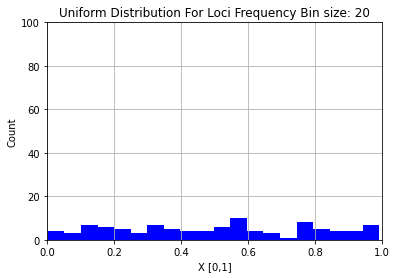

In [7]:
#use this to see distribution of f_i frequency
bin_size = 20
count, bins, ignored = plt.hist(f_M, 20, facecolor='blue') 

plt.xlabel('X [0,1]')
plt.ylabel('Count')
plt.title("Uniform Distribution For Loci Frequency Bin size: "+str(bin_size))
plt.axis([0, 1, 0, 100]) # x_start, x_end, y_start, y_end
plt.grid(True)

plt.show(block = False)

In [8]:
#starting machine learning classification
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn import svm

In [9]:
#split data into test and train
X = G[:,0:len(G[0])-2]

#last column is the appended Y vector we predicted
y = G[:,len(G[0])-1]

#split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [10]:
#regression model of SVM with RBF kernal
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

In [11]:
# train the model
svr_rbf.fit(x_train, y_train)

#test the model on test data
y_predict = svr_rbf.predict(x_test)

In [12]:
#Evaluate the regression model
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_predict), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_predict), 2)) 
print("Root Mean squared error =", sqrt(round(sm.mean_squared_error(y_test, y_predict), 2)))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_predict), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_predict), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_predict), 2))

Mean absolute error = 0.32
Mean squared error = 0.17
Root Mean squared error = 0.41231056256176607
Median absolute error = 0.27
Explain variance score = 0.0
R2 score = -0.0
